In [172]:
# -*- coding: utf-8 -*-

# In this script we use a simple classifer called naive bayes and try to predict the violations. But before that we use
# some methods to tackle the problem of our skewed dataset. :) 

# 11 May 2016
# @author: reyhane_askari
# Universite de Montreal, DIRO

import csv
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from os import chdir, listdir
from pandas import read_csv
from os import path
from random import randint, sample, seed
from collections import OrderedDict
from pandas import DataFrame, Series
import numpy as np 
import csv
import codecs
import matplotlib as mpl
import seaborn as sns
sns.set()
import itertools
from sklearn.decomposition import PCA
from unbalanced_dataset import UnderSampler, NearMiss, CondensedNearestNeighbour, OneSidedSelection,\
NeighbourhoodCleaningRule, TomekLinks, ClusterCentroids, OverSampler, SMOTE,\
SMOTETomek, SMOTEENN, EasyEnsemble, BalanceCascade

almost_black = '#262626'

%matplotlib inline

In [173]:
colnames = ['old_index','job_id', 'task_idx','sched_cls', 'priority', 'cpu_requested',
            'mem_requested', 'disk', 'violation'] 

tain_path = r'/Users/reyhane.askari/Dropbox/Project_step_by_step/3_create_database/csvs/frull_db_2.csv'

X = pd.read_csv(tain_path, header = None, index_col = False ,names = colnames, skiprows = [0],  usecols = [3,4,5,6,7])
y = pd.read_csv(tain_path, header = None, index_col = False ,names = colnames, skiprows = [0],  usecols = [8])
y = y['violation'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.333, random_state=0)
x = X.values

In [174]:
# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components = 2)

# Fit and transform x to visualise inside a 2D feature space
x_vis = pca.fit_transform(x)
# Plot the original data
# Plot the two classes
palette = sns.color_palette()

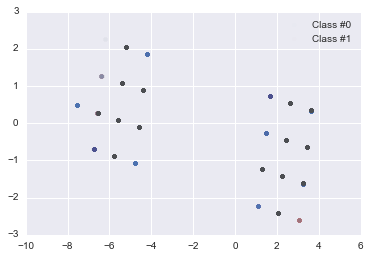

In [175]:
plt.scatter(x_vis[y==0, 0], x_vis[y==0, 1], label="Class #0", alpha=0.009, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
plt.scatter(x_vis[y==1, 0], x_vis[y==1, 1], label="Class #1", alpha=0.009, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)

plt.legend()
plt.show()

In [176]:
# Generate the new dataset using under-sampling method
verbose = False

In [6]:
# 'Random under-sampling'
US = UnderSampler(verbose=verbose)
x, y = US.fit_transform(x, y)

In [ ]:
# 'Clustering centroids'
CC = ClusterCentroids(verbose=verbose)
x, y = CC.fit_transform(x, y)

In [6]:
# 'NearMiss-1'
NM1 = NearMiss(version=1, verbose=verbose)
x, y = NM1.fit_transform(x, y)

In [16]:
# 'NearMiss-2'
NM2 = NearMiss(version=2, verbose=verbose)
x, y = NM2.fit_transform(x, y)

In [30]:
# 'NearMiss-3'
NM3 = NearMiss(version=3, verbose=verbose)
x, y = NM3.fit_transform(x, y)

In [60]:
# 'One-Sided Selection'
OSS = OneSidedSelection(size_ngh=51, n_seeds_S=51, verbose=verbose)
x, y = OSS.fit_transform(x, y)

In [74]:
# 'Neighboorhood Cleaning Rule'
NCR = NeighbourhoodCleaningRule(size_ngh=51, verbose=verbose)
x, y = NCR.fit_transform(x, y) 

In [177]:
ratio = float(np.count_nonzero(y==1)) / float(np.count_nonzero(y==0))

In [89]:
# 'Random over-sampling'
OS = OverSampler(ratio=ratio, verbose=verbose)
x, y = OS.fit_transform(x, y)

In [104]:
# 'SMOTE'
smote = SMOTE(ratio=ratio, verbose=verbose, kind='regular')
x, y = smote.fit_transform(x, y)

In [134]:
# 'SMOTE bordeline 1'
bsmote1 = SMOTE(ratio=ratio, verbose=verbose, kind='borderline1')
x, y = bsmote1.fit_transform(x, y)

In [149]:
# 'SMOTE bordeline 2'
bsmote2 = SMOTE(ratio=ratio, verbose=verbose, kind='borderline2')
x, y = bsmote2.fit_transform(x, y)

In [ ]:
# 'SMOTE SVM'
svm_args={'class_weight' : 'auto'}
svmsmote = SMOTE(ratio=ratio, verbose=verbose, kind='svm', **svm_args)
x, y = svmsmote.fit_transform(x, y)

In [178]:
# 'SMOTE Tomek links'
STK = SMOTETomek(ratio=ratio, verbose=verbose)
x, y = STK.fit_transform(x, y)

In [163]:
# 'SMOTE ENN'
SENN = SMOTEENN(ratio=ratio, verbose=verbose)
x, y = SENN.fit_transform(x, y)

In [ ]:
# 'EasyEnsemble'
EE = EasyEnsemble(verbose=verbose)
x, y = EE.fit_transform(x, y)

In [ ]:
# 'BalanceCascade'
BS = BalanceCascade(verbose=verbose)
x, y = BS.fit_transform(x, y)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.333, random_state=0)

The scores.mean is : 0.968319


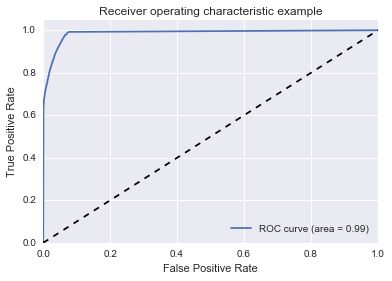

Number of mislabeled points out of a total 67454 points : 2040
The mean accuracy is : 0.969698


In [180]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

clf = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf, X_test, y_test)
print("The scores.mean is : %f" %scores.mean())

y_pred = clf.fit(X_train, y_train).predict(X_test)
y_score = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]


mean_accuracy = clf.fit(X_train, y_train).score(X_test,y_test,sample_weight=None)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.savefig('/Users/reyhane.askari/Dropbox/Project_step_by_step/3_create_database/random_forest.png')
plt.show()
print("Number of mislabeled points out of a total %d points : %d"
    % (X_test.shape[0],(y_test != y_pred).sum()))
print("The mean accuracy is : %f" %mean_accuracy)

In [181]:
from sklearn import metrics
metrics.precision_score(y_test, y_pred)

0.9452469711090401

In [182]:
metrics.recall_score(y_test, y_pred)

0.6920846127601501

In [183]:
 metrics.fbeta_score(y_test, y_pred, beta=0.5)  

0.88080764220581842

In [184]:
 metrics.fbeta_score(y_test, y_pred, beta=1)  

0.79909395312192244

In [185]:
metrics.fbeta_score(y_test, y_pred, beta=2)

0.73125450612833442

In [171]:
metrics.precision_recall_fscore_support(y_test, y_pred, beta=0.5) 

(array([ 0.9998121 ,  0.99875591]),
 array([ 0.99991458,  0.99726708]),
 array([ 0.9998326 ,  0.99845779]),
 array([58537,  4025]))